**Professor:** Enrique Garcia Ceja
**email:** enrique.gc@tec.mx

### Ariel López García A01275913




# Exercise: Detecting hand gestures from muscle electrical activity with an Ensemble of Neural Networks.

In this exercise you will train your first deep neural network to detect hand gestures from muscle activity. In fact, you will build two deep neural networks and ensemble them.

The data was collected with a MYO armband electromyography (EMG) sensor (see image below). The data was made available by Kirill Yashuk and can be downloaded [here](https://www.kaggle.com/kyr7plus/emg-4). The armband has 8 sensors that measure electrical activity at a sampling rate of 200Hz.
The dataset contains 4 different gestures: <font color=blue>0-rock, 1-scissors, 2-paper, 3-OK.</font>
The data contains 65 columns. The last column is the class label from 0 to 3. The first 64 columns are electrical measurements. 8 consecutive readings for each of the 8 sensors. The objective is to use the first 64 variables to predict the class.

<table><tr><td><img src="https://github.com/enriquegit/ap-img/blob/main/img/myoband.jpg?raw=true" width="200"></td><td><img src="https://github.com/enriquegit/ap-img/blob/main/img/dnn.png?raw=true" width="200"></td></tr></table>

## Instructions

In this exercise you will train *two* neural networks and combine their results to produce the final predictions. During training time, you train the two networks with the same train data but each network should have a different architecture. There is no point of building the same two networks because they will produce the same predictions. At test time, a given instance is fed into both networks. Each network outputs the predicted probabilities for each class (by specifying the last activation to be softmax). One way to combine the predictions of both networks is to multiply the output probabilities and predict the class with the highest one. When more than two models compose the ensemble, majority voting can also be used.

1. First, you need to randomly split the dataset into several subsets to avoid overfitting. Specifically, you will need **4 subsets**:

<table><tr><td><img src="https://github.com/enriquegit/ap-img/blob/main/img/splits.png?raw=true" width="250"></td></tr></table>

  - **train set (60%):** This one is used to train the two models.
  - **val1 set (10%):** This is used to fine tune parameters of your nueral networks.
  - **val2 set (15%):** This one is used to validate the performance when combining the networks.
  - **test set (15%):** This one is used at the end only once to test the generalization performance of your model once you are happy with the performance on the *val2 set*.

2. Build and train a first neural network using the *train set*. Use the *val1 set* to estimate its performance and fine tune its parameters.

3. Build and train a second neural network using the *train set*. Use the *val1 set* to estimate its performance while fine tuning its parameters. This network needs to have a different architecture from the previous one.

4. Once you are happy with both networks, it is now time to combine them. Generate predictions on the *val2 set* with your two networks. The predictions should be the probabilities for each class (not the final class). Combine the probabilities of each network by multiplying them. Obtain the final predicted classes by selecting the class with the highest probability.

5. Evaluate the performance of the combined models and of each of the individual models on the same *val2 set*. The performance of the combined models should be better than the performance of the best individual model. If this is not the case, iterate from step 2.

6. Once you are happy with your results, evaluate the performance of the combined models and each individual one on the *test set* just once.

### Tips:

- You can pass your validation data to the `fit` function with the `validation_data` argument, e.g., `model.fit(..., validation_data = (val1_features, val1_labels))`.
- You can plot accuracy and loss curves to analyze your models behavior. See *demo_sports* notebook for an example.

*NOTE:* In this case it was suggested to train both models with the same train data. With *Bagging* [1], which is an ensemble learning method, instead of using the same train data, new train sets are generated with bootstrapping. To construct a dataset, the method samples $N$ data points from the original train set where $N$ is the number of elements on the original train set. The sampling is made *with replacement*. Thus, the new set will contain duplicates and some elements of the original data set will not be present. The purpose of this is to have different models. If the same data is used to train them, they will be very similar and there is no need to train several of them. It is left as an exercise for the reader to implement bootstraping instead of using the same train set.

[1] Breiman, L. (1996). Bagging predictors. Machine learning, 24(2), 123-140.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import Model
from sklearn.metrics import accuracy_score, recall_score
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
# Read the data
dataset = pd.concat(
    map(pd.read_csv, ['datasets/0.csv', 'datasets/1.csv', 'datasets/2.csv', 'datasets/3.csv']), ignore_index=True)

seed = 123 #set seed for reproducibility
np.random.seed(seed)
dataset = shuffle(dataset) #shuffle rows




# Since there are not too many missing values we will just drop rows that contain missing values.
dataset = dataset.dropna()

# Print the dataset size after removing rows with missing values.
print(dataset.shape)

(11630, 65)


In [ ]:
# Print first rows of data.
dataset.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V56,V57,V58,V59,V60,V61,V62,V63,V64,label
550,-12,-4,-18.0,-59,-2,28,5,-22,11.0,4,...,31,19.0,1.0,1,-1,-5,9.0,-42,-32,rock
7169,8,13,8.0,1,-22,-5,-2,10,2.0,-9,...,0,1.0,2.0,3,-4,-7,13.0,-1,0,paper
6458,19,8,-1.0,3,6,-18,-1,-11,-4.0,7,...,-2,-15.0,-7.0,5,5,16,26.0,10,-8,paper
9330,-3,-4,1.0,0,1,47,10,1,4.0,-1,...,15,-10.0,-14.0,-9,-8,-7,-13.0,-8,-16,ok
3100,-3,-8,1.0,0,-39,-33,0,14,17.0,2,...,12,-11.0,1.0,4,0,-8,-16.0,1,4,scissors


In [ ]:
# Convert features and class to numpy arrays.
features = dataset.drop('label', axis=1)

labels = dataset[['label']]

features = features.values

labels = labels.values

Neural networks need the labels to be one-hot encoded. Currently, our labels are stored as strings. First we need to convert them into integers.

In [ ]:
# Convert labels to integers and store the result in labels_int
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

labels_int = le.fit_transform(labels.ravel())

# Display first 5 labels as strings.
print(labels[0:5])

# Display first 5 labels as integers.
print(labels_int[0:5]) # display first labels

[['rock']
 ['paper']
 ['paper']
 ['ok']
 ['scissors']]
[2 1 1 0 3]


In [ ]:
# One hot encode the labels and store the result in a variable called 'labels'
# You can use tf.keras.utils.to_categorical() function. Its first argument is an array of ints (e.g., labels_int)
# The second argument is the number of classes.

labels = tf.keras.utils.to_categorical(labels_int, 4)

In [ ]:
# Print first five one-hot encoded labels

labels[0:5,]

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]])

## Step 1: Split the data.

As explained in step 1 from the instructions section, the *train set* (60%) should consist of aprox. 6978 instances. The *val1 set* (10%) should have aprox. 1163 instances. The *val2 set* (15%) and the *test set* (15%) should have aprox. 1744 instances each.

In [ ]:
# Currently, the features are stored in the 'features' variable and the labels in 'labels'.
# First split into 2 subsets. train set = 60% (6978 instances) and a temporal set that contains the rest of the data (40%).
# We will use the train_test_split() function.
# The train_size argument specifies the number of instances to be included in the train set.

train_features, tmp_features, train_labels, tmp_labels = train_test_split(features, labels,
                                                                            train_size = 6978, random_state=1234)

# Now train_features and train_labels contain the train set.
# tmp_features and tmp_labels contain the rest of the data.

# Let's print the shape of the train set. It should now contain 6978 instances.
print(train_features.shape)
print(train_labels.shape)

(6978, 64)
(6978, 4)


In [ ]:
# Now, tmp_features has 40% of the total original data.
# We need to split tmp_features and tmp_labels into the remaining test, val1 and val2 sets.
# We can start by spliting tmp_features into two subsets.
# The first subset correspons to the 10% of the total (1163 instances) of the val1 data.
# The second subset is the remaining 30% of the total which will be split later into 15% for test and 15% for val2.

# Use the train_test_split() function to split tmp_features and tmp_labels.
# Store 10% of the TOTAL dataset into val1_features, val1_labels and the remaining into tmp2_features and tmp2_labels.

#### YOUR CODE HERE ####
val1_features, tmp2_features, val1_labels, tmp2_labels = train_test_split(tmp_features, tmp_labels,
                                                                            train_size = 1162, random_state=1234)


# Print size of val1 set. It should have 1163 instances.
print(val1_labels.shape)

(1162, 4)


In [ ]:
# Now, tmp2_features, tmp2_labels contains 30% of the TOTAL dataset.
# Split tmp2_features, tmp2_labels into two equally sized datasets.
# test_features, test_labels and val2_features, val2_labels.

#### YOUR CODE HERE ####
val2_features, test_features, val2_labels, test_labels = train_test_split(tmp2_features, tmp2_labels,
                                                                            train_size = 1745, random_state=1234)


# Print test and val2 sizes. Their sizes should be aprox. 1744.
print(test_labels.shape)
print(val2_labels.shape)

(1745, 4)
(1745, 4)


Noramlize the features between 0 and 1. Remember that normalization parameters are learned just from the training data.

In [ ]:
# Normalize features between 0 and 1.
# Remember that normalization parameters are learned just from the training data.

# Learn parameters from train set.
normalizer = preprocessing.MinMaxScaler().fit(train_features)

# Use the learned normalizer to normalize train_features and store the result in train_normalized.
train_normalized = normalizer.transform(train_features)

# Use the learned normalizer to normalize test_features and store the result in test_normalized.
#### YOUR CODE HERE ####
test_normalized = normalizer.transform(test_features)

# Use the learned normalizer to normalize val1_features and store the result in val1_normalized.
#### YOUR CODE HERE ####
val1_normalized = normalizer.transform(val1_features)

# Use the learned normalizer to normalize val2_features set and store the result in val2_normalized.
#### YOUR CODE HERE ####
val2_normalized = normalizer.transform(val2_features)


# Step 2: Build and evaluate model 1.

Now it is time to build model 1 (the first neural network). Use the keras Sequential API to build a deep network (at least 2 hidden layers). Store the model in a variable `model1`.

In [ ]:
# Define your neural network's architecture (layers, neurons, etc.).
# The first Dense layer should include the input_shape, i.e., the number of input variables.
# The following layers do not need an input_shape argument.
# Since this is a classificaton problem, the last layer should have softmax as activation function.
# keras.Sequential() expects a list of layers, e.g., keras.layers.Dense() which is a fully connected layer.
# The number of neurons of a dense layer can be specified with the 'units' argument.
# The activation function is specified with the 'activation' argument.

#### COMPLETE THE CODE ####
model1 = keras.Sequential([
    keras.layers.Dense(units = 16, input_shape=(64,), activation=tf.nn.relu),
    keras.layers.Dense(units = 8, activation=tf.nn.relu),
    keras.layers.Dense(units = 4, activation=tf.nn.softmax)
])


# Print the model summary.
print(model1.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │              36 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,212 (4.73 KB)

 Trainable params: 1,212 (4.73 KB)

 Non-trainable params: 0 (0.00 B)

None


### Define optimizer and compile the model

In [ ]:
# We can use for example, Stochastic Gradient Descent as the optimizer.

# Set a learning rate for the opimizer.
lr = .001 #### COMPLETE THE CODE ####

# Instantiate the optimzier with the specified learning rate.
optimizer = tf.keras.optimizers.SGD(lr)

# Compile the model.
# Since this is a classification problem we need "categorical_crossentropy" as the loss function.
model1.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ['accuracy'])

In [ ]:
# Train the model with the normalized train set using the fit() function.
# Use the normalized val1 set as validation data. You can do so with the 'validation_data' argument of the fit() function
# that accepts a tuple as argument: model1.fit(..., validation_data = (val1_normalized, val1_labels))
# Remember to set the number of epochs and the batch_size.

# NOTE: After fitting a model its state is saved. If you change hyperparameters (learning rate, epohcs, etc.)
# you should reinstantiate the model for example by re-reunning: model1 = keras.Sequential([....]]
# compile the model again and fit.

#### COMPLETE THE CODE ####
history = model1.fit(train_normalized, train_labels,validation_data = (val1_normalized, val1_labels),
                    epochs = 325, validation_split = 0.2, batch_size = 8, verbose = 1
)

Epoch 1/325
873/873 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2391 - loss: 1.3993 - val_accuracy: 0.2238 - val_loss: 1.3890
Epoch 2/325
873/873 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2338 - loss: 1.3855 - val_accuracy: 0.2590 - val_loss: 1.3838
Epoch 3/325
873/873 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2616 - loss: 1.3830 - val_accuracy: 0.2780 - val_loss: 1.3820
Epoch 4/325
873/873 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2815 - loss: 1.3810 - val_accuracy: 0.2806 - val_loss: 1.3806
Epoch 5/325
873/873 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2753 - loss: 1.3798 - val_accuracy: 0.2883 - val_loss: 1.3797
Epoch 6/325
873/873 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2935 - loss: 1.3795 - val_accuracy: 0.2926 - val_loss: 1.3791
Epoch 7/325
873/873 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3017 - loss: 1.3790 - val_accuracy: 0.2960 - val_loss: 1.3787
Epoch 8/325
873/873 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2922 - loss: 1.3788 - val_accu

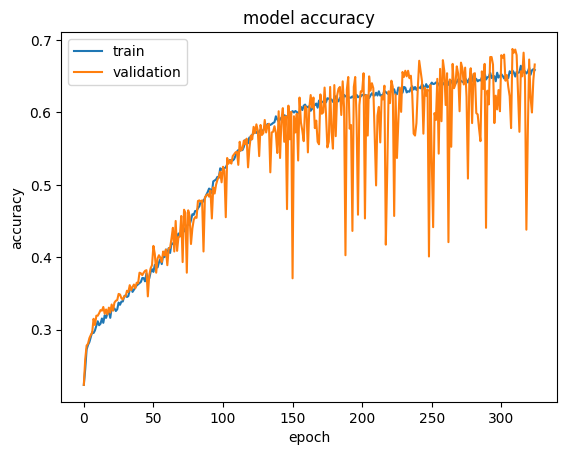

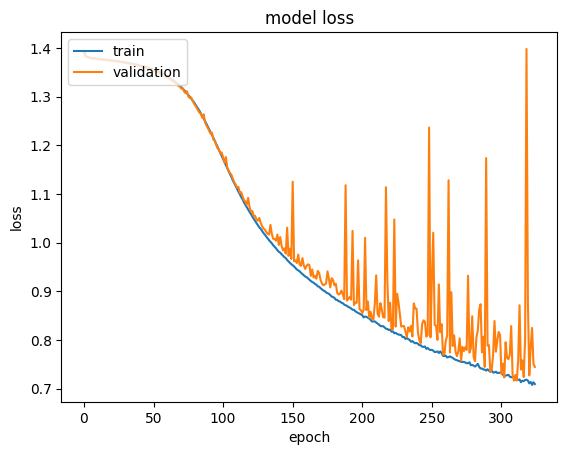

In [ ]:
# Plot the accuracy and loss curves.
# Based on the validation accuracy and curves, fine tune your model,
# for example by changing the number of epochs, learning rate, network architecture, etc.

import matplotlib.pyplot as plt
%matplotlib inline
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Evaluate the performance on *val1 set*.**

In [ ]:
# The evaluate() function can be used to evaluate the model on a specified dataset.
# It returns the loss and the metrics specified in fit(), in this case 'accuracy'.
# The following code prints the final loss and accuracy and should be the same as printed in the last epoch.
model1.evaluate(val1_normalized, val1_labels) #[loss, accuracy]

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6645 - loss: 0.7312 


[0.7445253729820251, 0.6660929322242737]

# Step 3: build and evaluate model 2.

Build another network. This one should have a different architecture from `model1`.
Store the model in a variable `model2`.

In [ ]:
#### YOUR CODE HERE ####
model2 = keras.Sequential([
    keras.layers.Dense(units = 16, input_shape=(64,), activation=tf.nn.leaky_relu),
    keras.layers.Dense(units = 8, activation=tf.nn.leaky_relu),
    keras.layers.Dense(units = 4, activation=tf.nn.softmax)
])
#Se intentó con sigmodides, probablemente funcione mejor con leaky_relu
# Print model summary.
print(model2.summary())



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │              36 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,212 (4.73 KB)

 Trainable params: 1,212 (4.73 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Instantiate an optimizer and specify the learning rate.

#### YOUR CODE HERE ####

lr = .001


# Compile the model with the instantiated optimizer.
#### YOUR CODE HERE ####

optimizer = tf.keras.optimizers.SGD(lr)

# Compile the model.
# Since this is a classification problem we need "categorical_crossentropy" as the loss function.
model2.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ['accuracy'])

In [ ]:
# Train the model with the normalized train set. Remember to set the number of epochs,
# the validation_data and batch_size.

#### COMPLETE THE CODE ####
history2 = model2.fit(train_normalized, train_labels,validation_data = (val1_normalized, val1_labels),
                    epochs = 325, validation_split = 0.2, batch_size = 8, verbose = 1
)

Epoch 1/325
873/873 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2571 - loss: 1.4092 - val_accuracy: 0.2539 - val_loss: 1.3886
Epoch 2/325
873/873 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2498 - loss: 1.3865 - val_accuracy: 0.2341 - val_loss: 1.3894
Epoch 3/325
873/873 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2357 - loss: 1.3880 - val_accuracy: 0.2427 - val_loss: 1.3893
Epoch 4/325
873/873 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2395 - loss: 1.3873 - val_accuracy: 0.2522 - val_loss: 1.3888
Epoch 5/325
873/873 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.2458 - loss: 1.3865 - val_accuracy: 0.2392 - val_loss: 1.3886
Epoch 6/325
873/873 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2508 - loss: 1.3863 - val_accuracy: 0.2487 - val_loss: 1.3882
Epoch 7/325
873/873 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2442 - loss: 1.3867 - val_accuracy: 0.2496 - val_loss: 1.3881
Epoch 8/325
873/873 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2602 - loss: 1.3858 - val_accu

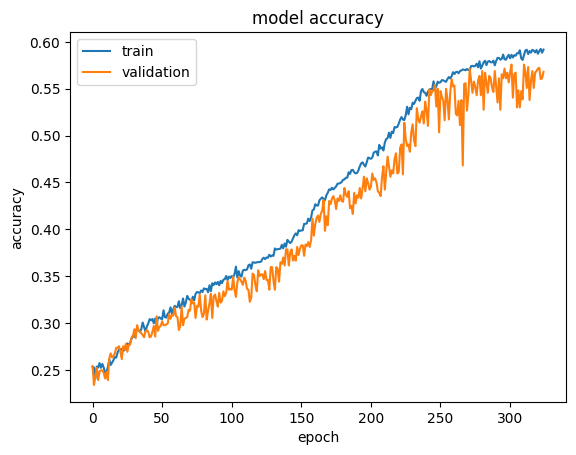

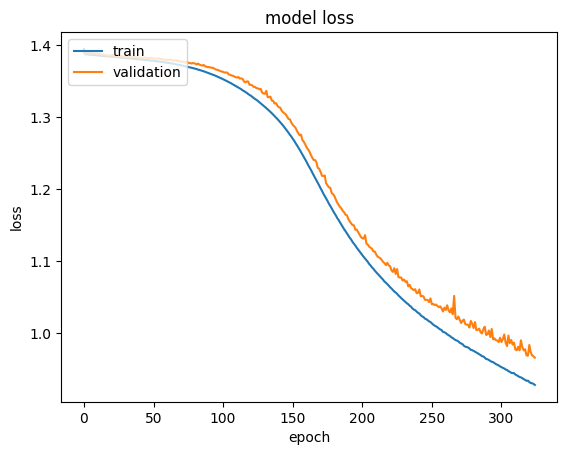

In [ ]:
# Plot the accuracy and loss curves.
# Based on the curves, fine tune your model, for example by changing the number of epochs, learning rate, network architecture, etc.

import matplotlib.pyplot as plt
%matplotlib inline
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Evaluate the performance on *val1 set*.**

In [ ]:
# Evaluate model2 using the evaluate() function.

#### YOUR CODE HERE ####

model2.evaluate(val1_normalized, val1_labels)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5865 - loss: 0.9581 


[0.9657358527183533, 0.567986249923706]

# Step 4 and 5: Combine models and evaluate the performance on *val2 set*

In [ ]:
# To combine model1 and model2 we can obtain the actual predictions from each model using the predict() function.
# Its first argument is the features as numpy array.
# This function returns a vector of probabilities for each row.
# Each probability represents the likelihood of the corresponding class.

# Make predictions on the val2 set using model 1.
predictions1 = model1.predict(val2_normalized)

# Make predictions on the val2 set using model 2.
predictions2 = model2.predict(val2_normalized)

# Combine the predictions by multiplying the probabilities.
predictionsCombined = predictions1 * predictions2

# Print the combined predictions of the first 5 instances.
predictionsCombined[0:5,]

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([[1.07447684e-01, 7.26410374e-02, 9.43570340e-05, 1.50407955e-01],
       [1.00299820e-01, 1.78818956e-01, 3.54186669e-02, 2.39947462e-04],
       [8.87894407e-02, 7.98341781e-02, 7.56221339e-02, 1.13001261e-05],
       [9.14544389e-02, 6.20702989e-02, 8.86927446e-05, 1.88865155e-01],
       [1.40981466e-01, 1.12612315e-01, 6.83944789e-04, 5.13604507e-02]],
      dtype=float32)

In [ ]:
# Get the column index with max probability to get the predictions in integer format.
predictions_int = np.argmax(predictionsCombined, axis=1)

# Since the ground truth labels are also one-hot encoded we need to
# get the index of the maximum value to obtain the predictions in integer format.
true_values_int = np.argmax(val2_labels, axis=1)

# Convert back to strings
predictions_str = le.inverse_transform(predictions_int)

true_values_str = le.inverse_transform(true_values_int)

# Accuracy
print(accuracy_score(true_values_str, predictions_str))

# Recall
print(recall_score(true_values_str, predictions_str, average='macro'))

0.7083094555873926
0.7028009889685262


### Evaluate performance of model 1 with *val2 set*

In [ ]:
# Compute the accuracy and recall just for model1.

#### YOUR CODE HERE ####

model1.evaluate(val2_normalized, val2_labels)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6621 - loss: 0.7388


[0.7158387303352356, 0.6767908334732056]

### Evaluate performance of model 2 with *val2 set*

In [ ]:
# Compute the accuracy and recall just for model2.

#### YOUR CODE HERE ####

model2.evaluate(val2_normalized, val2_labels)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5801 - loss: 0.9251


[0.9134904146194458, 0.5959885120391846]

Was the performance of the combined models better than the other two models?
If yes, proceed to evaluate your models with the *test set*. If not, iterate from step 2-5.

# Step 6: Evaluate on test set

### Combined models

In [ ]:
# Evaluate the accuracy and recall of the combined models on the test set.

#### YOUR CODE HERE ####

predictions1 = model1.predict(test_normalized)
predictions2 = model2.predict(test_normalized)

predictionsCombined = predictions1 * predictions2

predictionsCombined[0:5,]
predictions_int = np.argmax(predictionsCombined, axis=1)

true_values_int = np.argmax(val2_labels, axis=1)

predictions_str = le.inverse_transform(predictions_int)

true_values_str = le.inverse_transform(true_values_int)

# Accuracy
print(accuracy_score(true_values_str, predictions_str))

# Recall
print(recall_score(true_values_str, predictions_str, average='macro'))
#Esro se dio porque dividimos 1163 el lote, debimos de hacerlo 1162 y ya nos darían el resultado de esta multiplicación

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
0.24584527220630373
0.24507881475686574


### Model 1

In [ ]:
# Evaluate the accuracy and recall of model1 on the test set.

#### YOUR CODE HERE ####

model1.evaluate(test_normalized, test_labels)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6484 - loss: 0.7364


[0.7534950375556946, 0.6395415663719177]

### Model 2

In [ ]:
# Evaluate the accuracy and recall of model*2* on the test set.

#### YOUR CODE HERE ####

model2.evaluate(test_normalized, test_labels)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5817 - loss: 0.9462


[0.9540066123008728, 0.5828080177307129]

Debido al tiempo no pudimos mejorar los resultados, sin embargo modificacndo las funciones de activación de la segunda red podríamos tener mucho mejores resultados



**This is the end of the exercise!**